# Import Packages

In [1]:
# import packages

import collections
import math
import matplotlib.pyplot as pp
import numpy as np
import tslearn.utils
import pandas as pd
from copy  import deepcopy
from datetime import datetime, timedelta
from fastdtw import fastdtw
import glob
from itertools import islice
from IPython.display import display
from math import sqrt
from matplotlib.pyplot import figure
from pandas import DataFrame
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
from scipy.stats import ttest_1samp
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_1samp
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series

%matplotlib inline

In [2]:
# set maximum viewing window (personal preference)
pd.set_option('display.max_rows', 500)

# Functions

In [3]:
# define formating function
def format_csv(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[['Adj Close']] ### drop all other columns
    df['Return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

In [4]:
# Attribute: https://github.com/srafay/Time-Series-Analysis-JetRail/blob/f5c25f4d481ddb8deaea09f2cff2d8585dcf6bb4/Jet_Rail.py#L197
# Author: Syed Rafay
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def test_stationarity(timeseries, w, title='Rolling Mean & Standard Deviation'): ### w: window size
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=w).mean()
    rolstd = timeseries.rolling(center=False,window=w).std()
    #Plot rolling statistics:
    pp.figure(figsize=(20,10))
    orig = pp.plot(timeseries, color='blue',label='Original')
    mean = pp.plot(rolmean, color='red', label='Rolling Mean')
    std = pp.plot(rolstd, color='green', label = 'Rolling Std')
    pp.legend(loc='best')
    pp.title(title)
    pp.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def detrend_takelog(df, w): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    moving_avg = Train_log.rolling(w).mean()
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.plot(df.index.values, moving_avg.values, color = 'red', label='Rolling_Mean(log(train))')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    # Remove the trend
    train_log_moving_avg_diff = Train_log - moving_avg
    ### option 1: NaN replaced by 0
    ### train_log_moving_avg_diff = train_log_moving_avg_diff.fillna(0) 
    ### option 2: drop NaN
    train_log_moving_avg_diff.dropna(inplace = True)
    test_stationarity(train_log_moving_avg_diff, w) # And from plot we can see that std is stable
    return train_log_moving_avg_diff.to_frame()

In [5]:
# Define Transformation Function that converts data into t chunks of equal length - for Adjusted Close Price
def transform(df_t, va, t): ### df_t: time-series data, va: variable, t: length of chunks
    X_array = np.array(df_t[[va]].dropna(inplace = False)) ### Convert X into Array
    residue = len(X_array) % t
    if residue:
        print("The array is not divisible into a", t, "dimensional array.")
        print("We omit the first", residue, "entry/entries in the dataset.")
    X_array = X_array[residue:] ### Crop the data into length divisible by t
    X_t = np.reshape(X_array, (-1, t)) ### Reshape for fitting
    return X_t

In [20]:
# Attribute: https://predictivehacks.com/k-means-elbow-method-code-for-python/
# Author: Billy Bonaros

def elbow(data, alg): ### data = X_t, alg = "dtw" or "euclidean"
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeanModel = TimeSeriesKMeans(n_clusters = k, metric = alg, max_iter = 25)
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)    
    pp.figure(figsize = (16, 8))
    pp.plot(K, distortions, 'bx-')
    pp.xlabel('k')
    pp.ylabel('Distortion')
    pp.title('The Elbow Method Showing the Optimal K')
    pp.show()

# Elbow Test

In [7]:
# read data
df_amc_train = format_csv(r'Data\AMC_train.csv')
df_gme_train = format_csv(r'Data\GME_train.csv')
df_bb_train = format_csv(r'Data\BB_train.csv')
df_nok_train = format_csv(r'Data\NOK_train.csv')

df_amc_train_hr = format_csv(r'Data\AMC_train_hr.csv')
df_gme_train_hr = format_csv(r'Data\GME_train_hr.csv')
df_bb_train_hr = format_csv(r'Data\BB_train_hr.csv')
df_nok_train_hr = format_csv(r'Data\NOK_train_hr.csv')

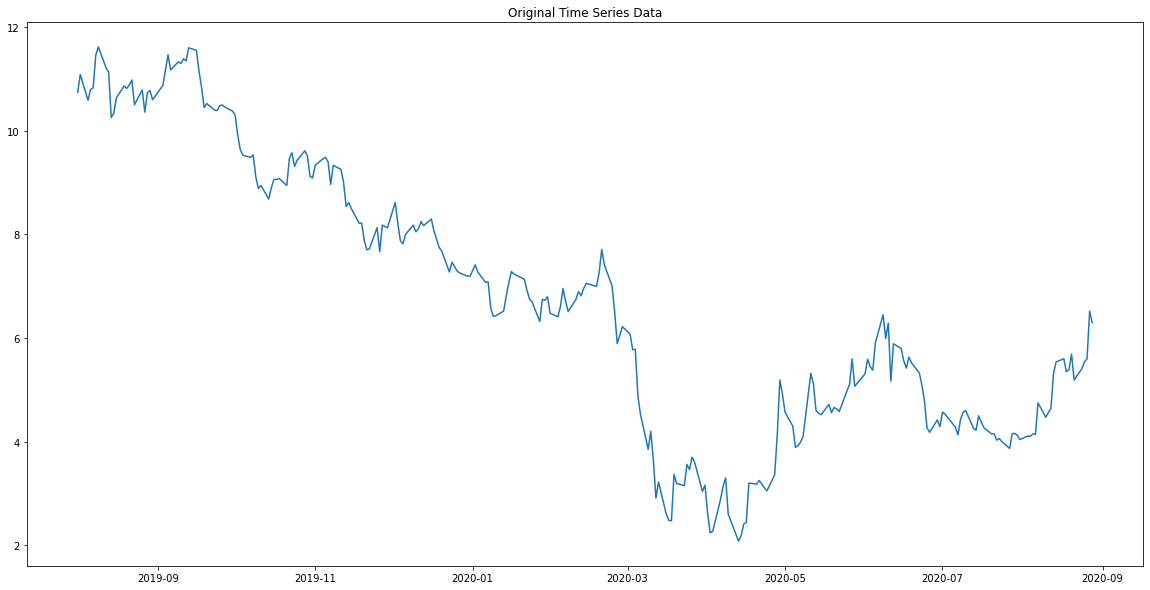

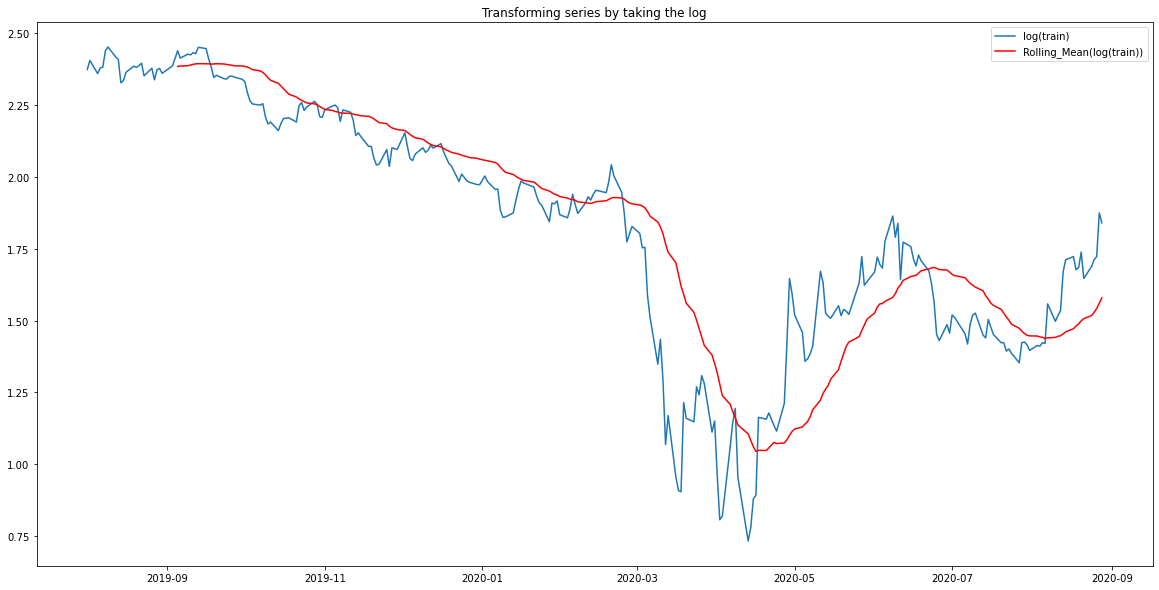

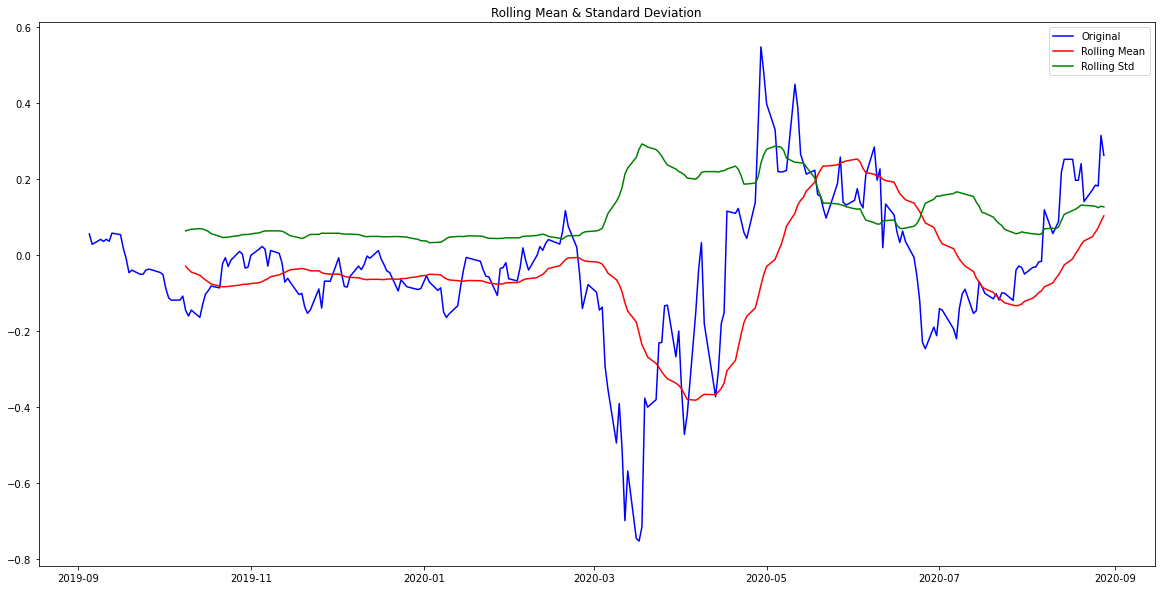

Results of Dickey-Fuller Test:
Test Statistic                  -3.002602
p-value                          0.034652
#Lags Used                       1.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


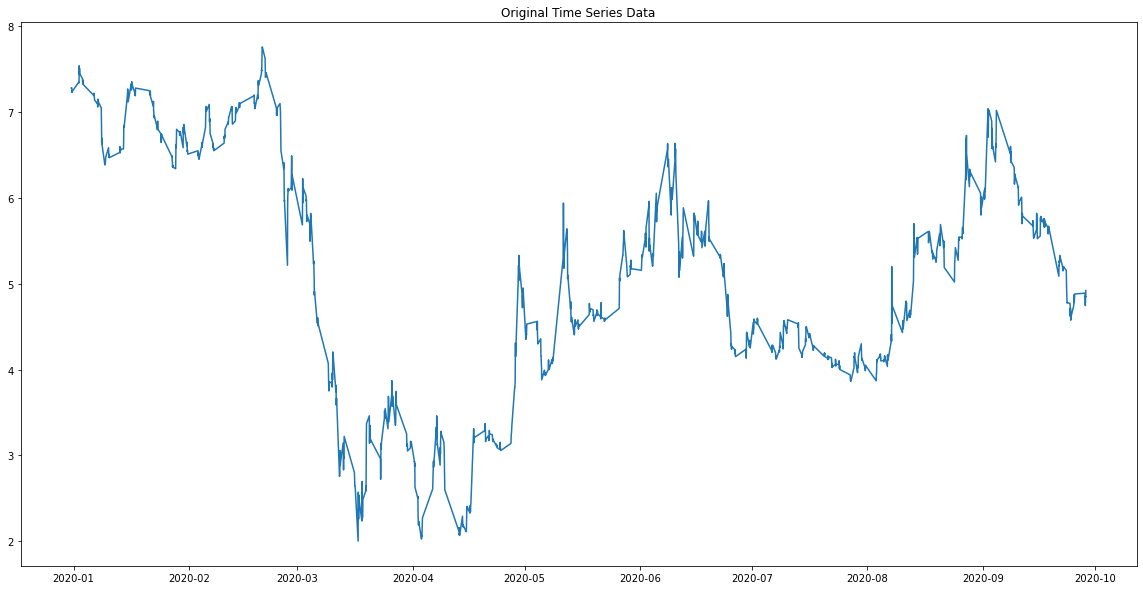

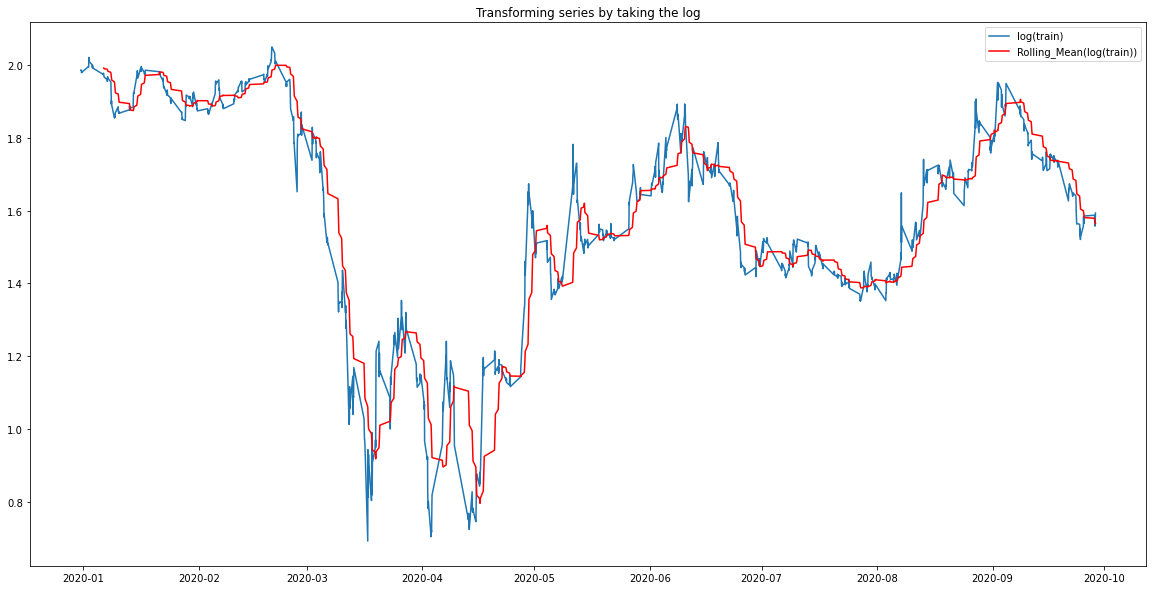

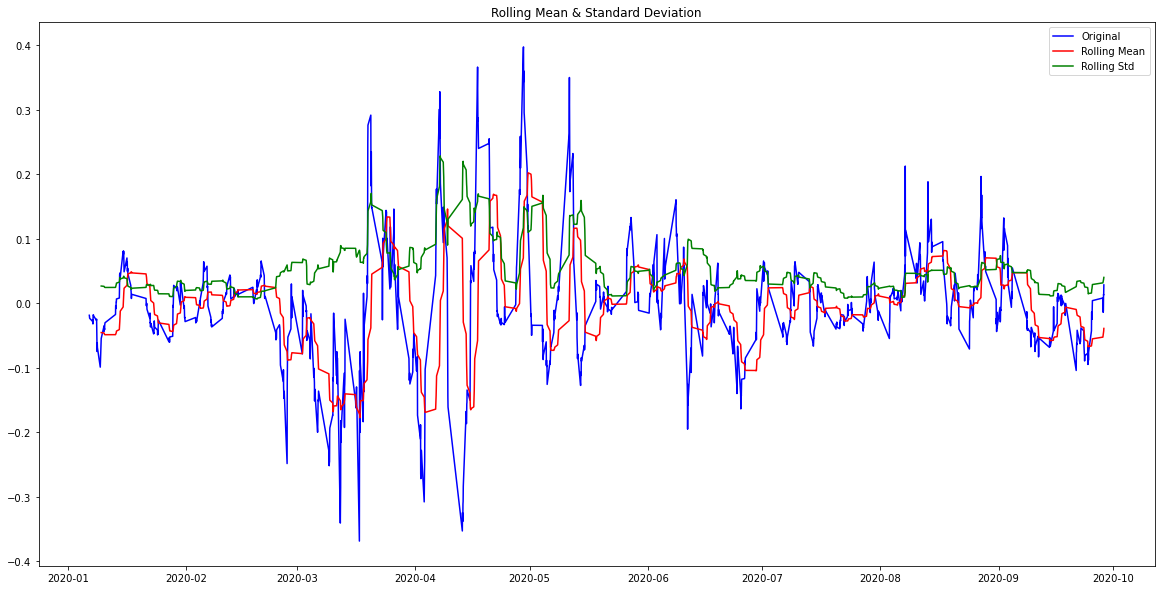

Results of Dickey-Fuller Test:
Test Statistic                -8.054445e+00
p-value                        1.707419e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.283000e+03
Critical Value (1%)           -3.435457e+00
Critical Value (5%)           -2.863795e+00
Critical Value (10%)          -2.567971e+00
dtype: float64


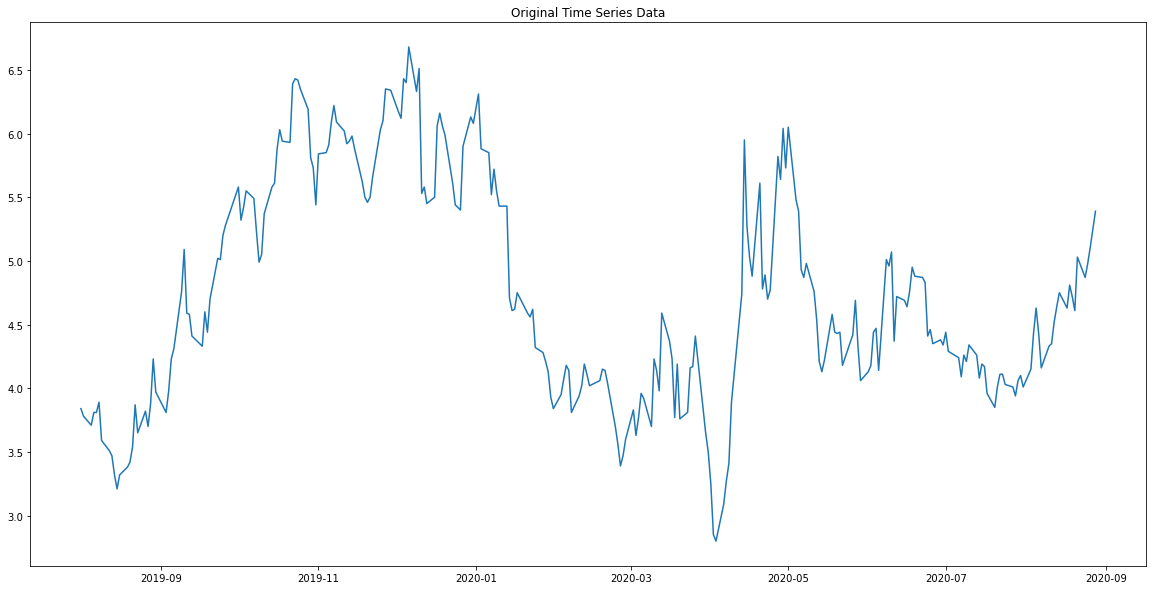

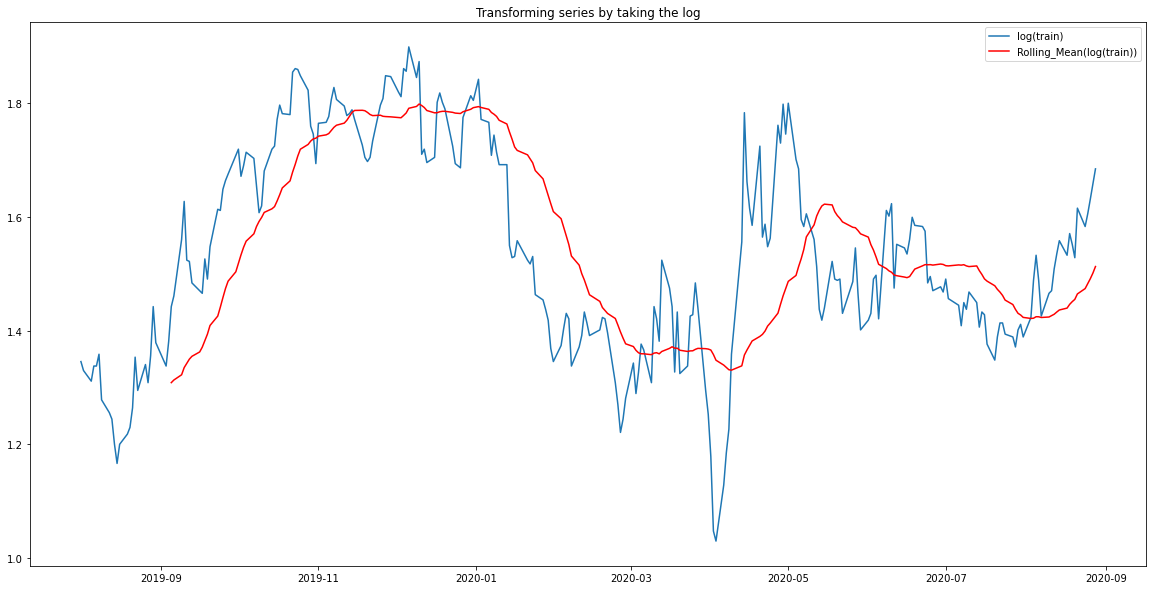

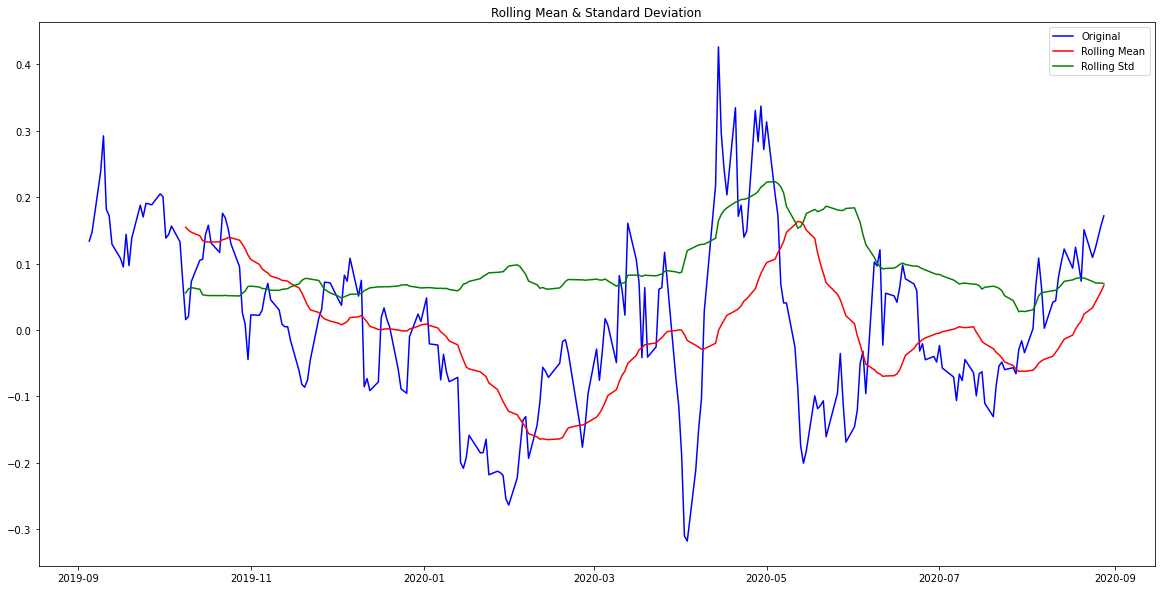

Results of Dickey-Fuller Test:
Test Statistic                  -3.216120
p-value                          0.019070
#Lags Used                       9.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


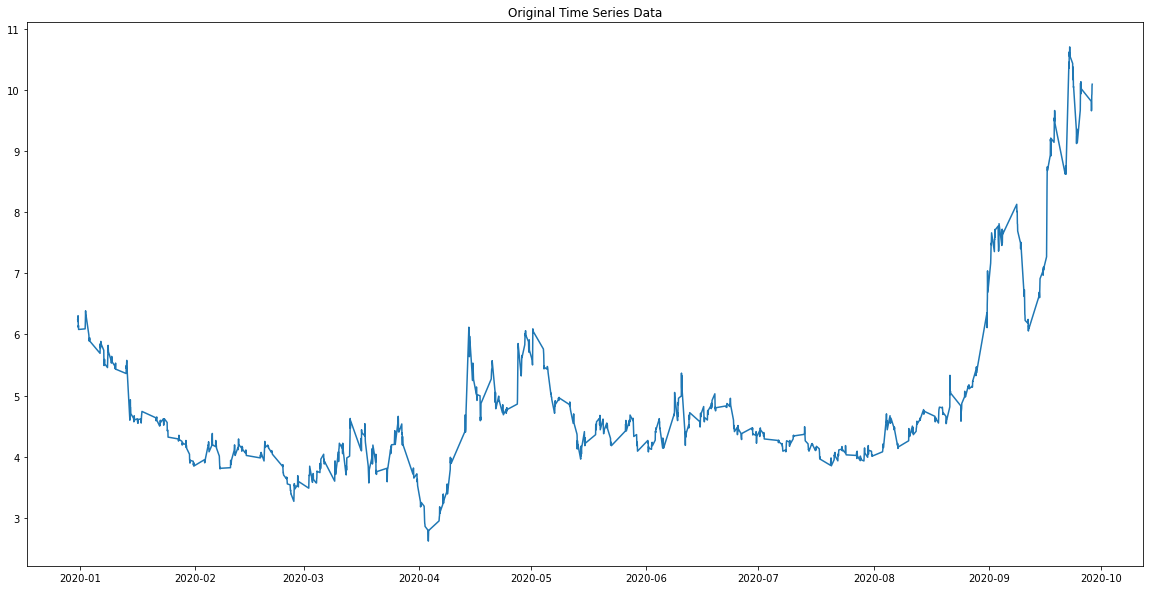

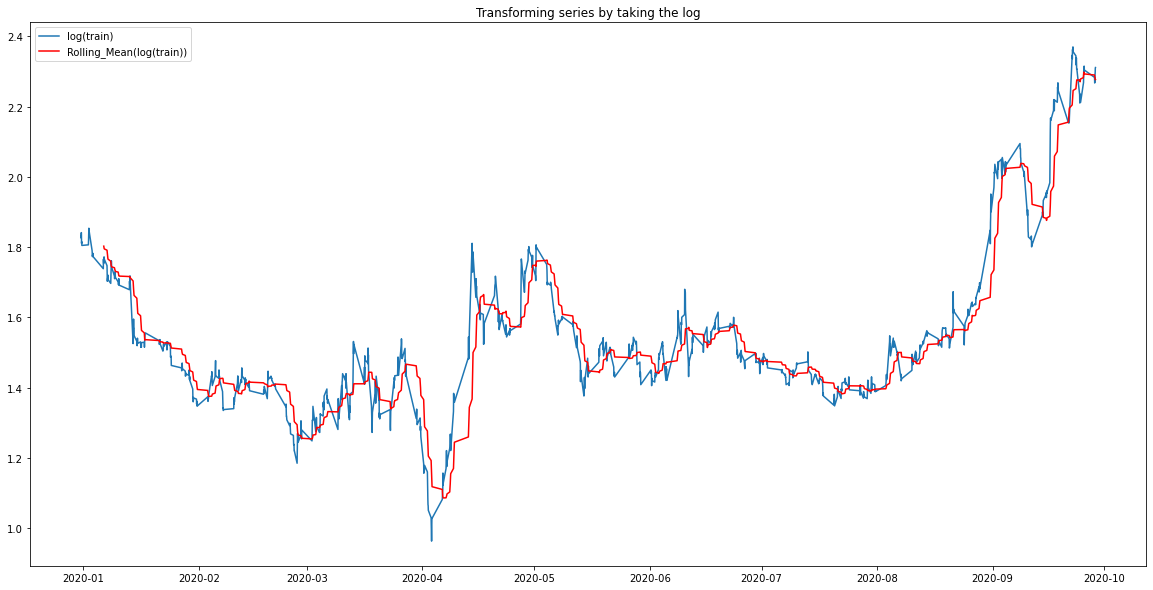

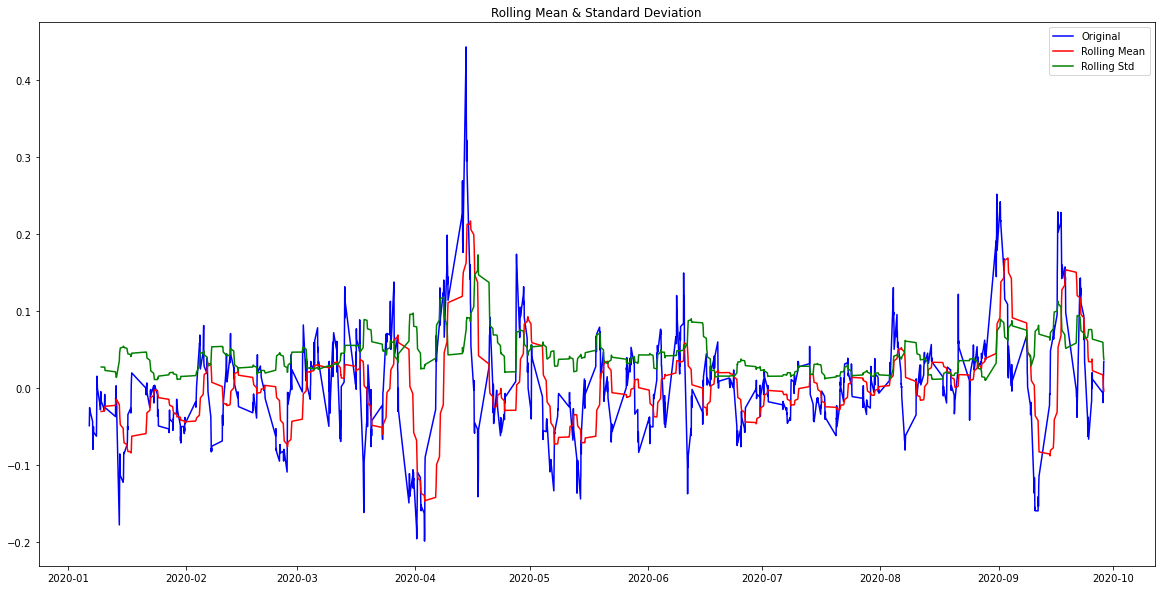

Results of Dickey-Fuller Test:
Test Statistic                -7.038896e+00
p-value                        5.916935e-10
#Lags Used                     6.000000e+00
Number of Observations Used    1.285000e+03
Critical Value (1%)           -3.435449e+00
Critical Value (5%)           -2.863792e+00
Critical Value (10%)          -2.567969e+00
dtype: float64


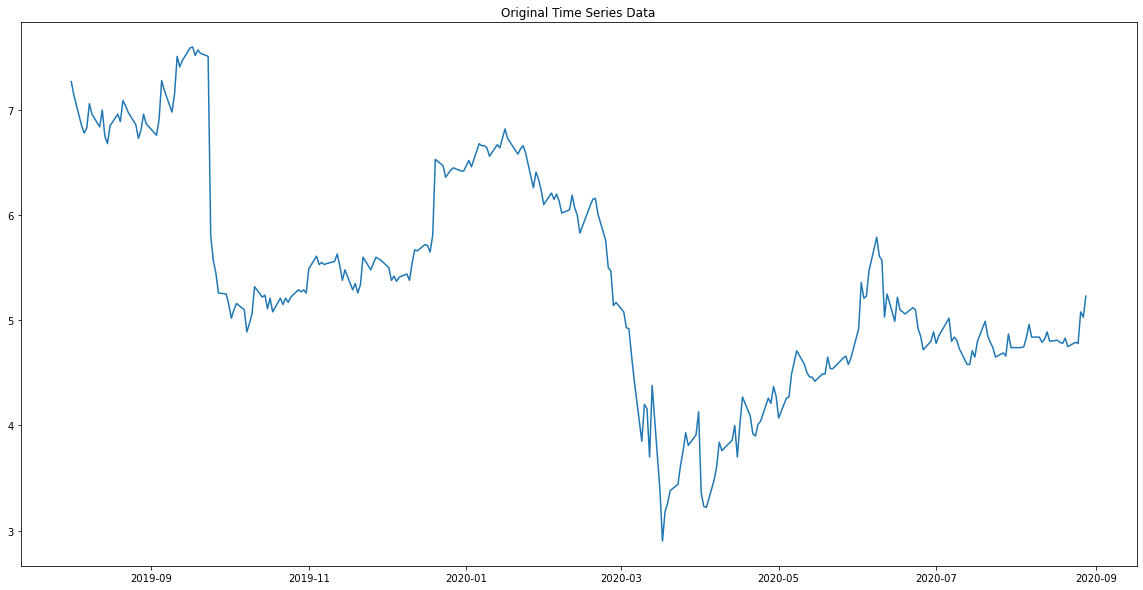

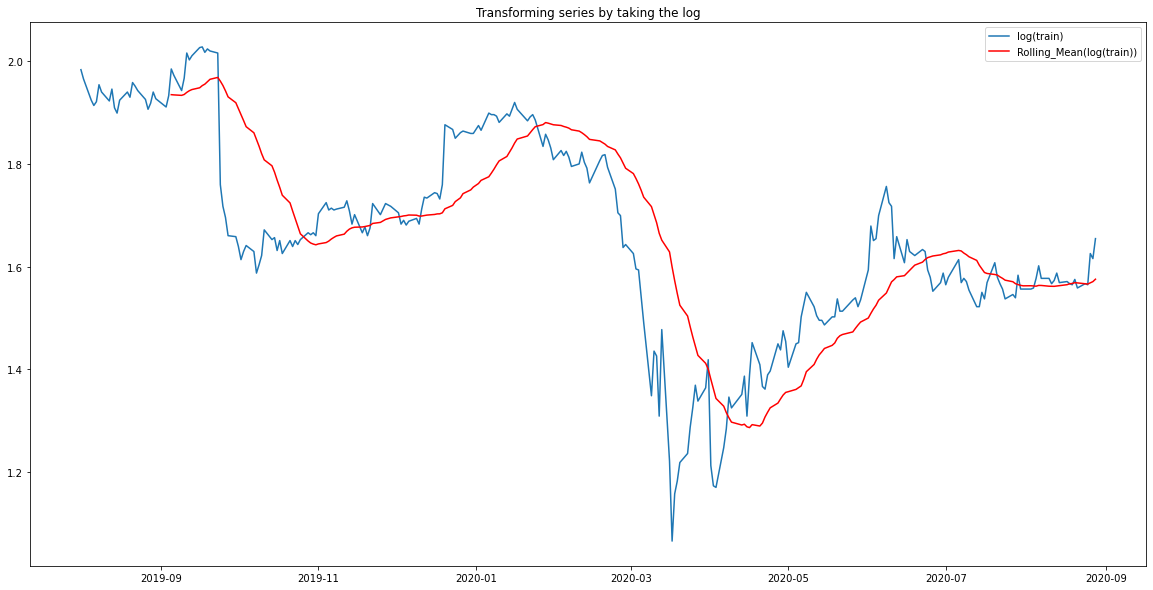

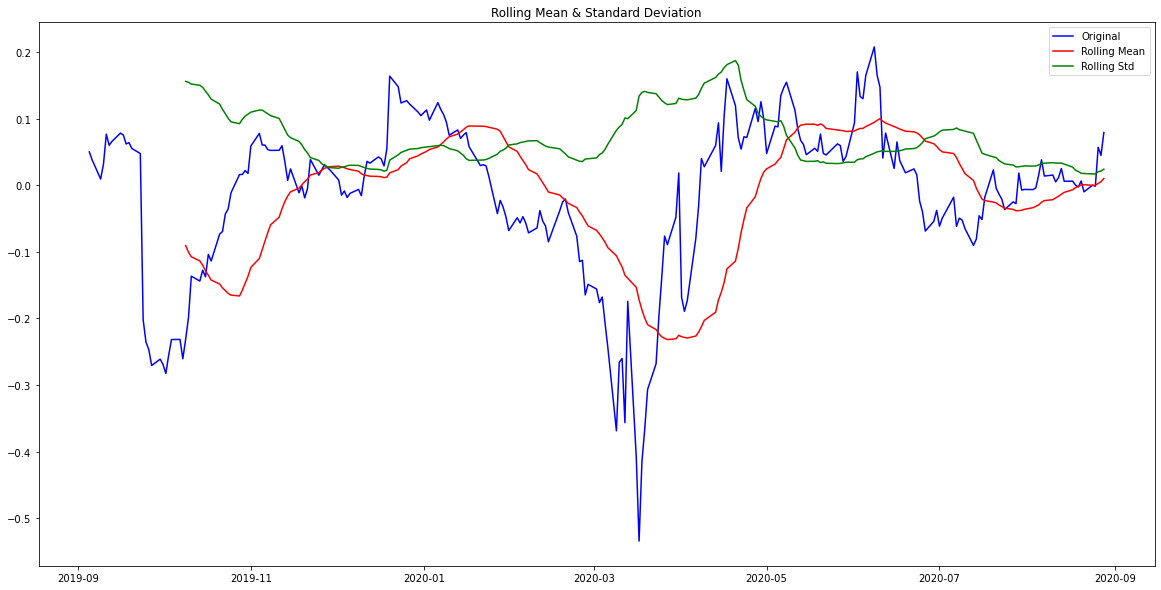

Results of Dickey-Fuller Test:
Test Statistic                  -2.831129
p-value                          0.053963
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


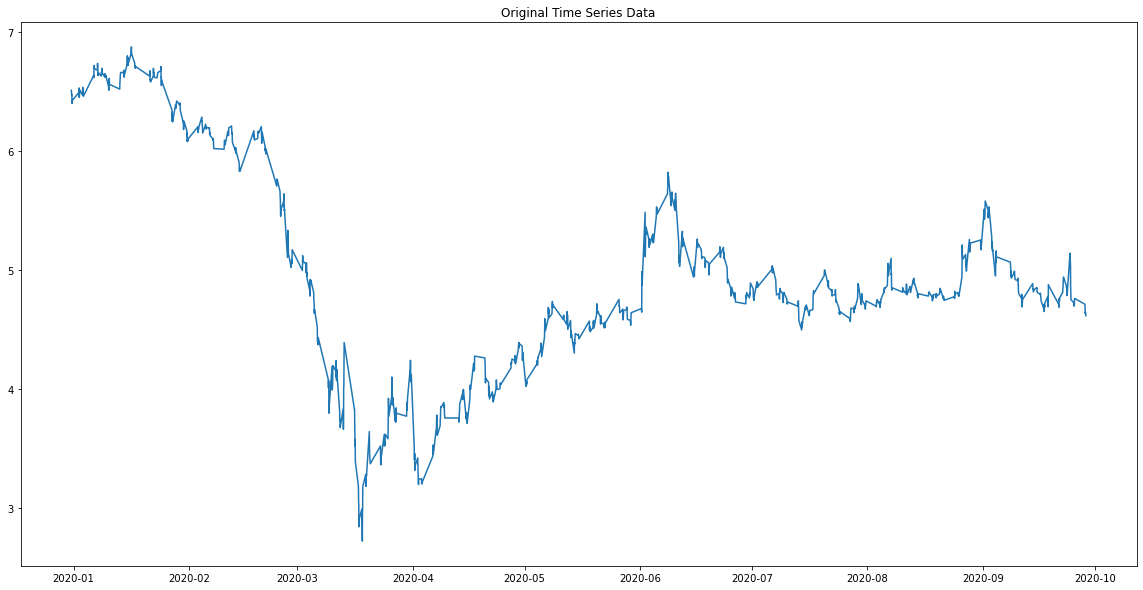

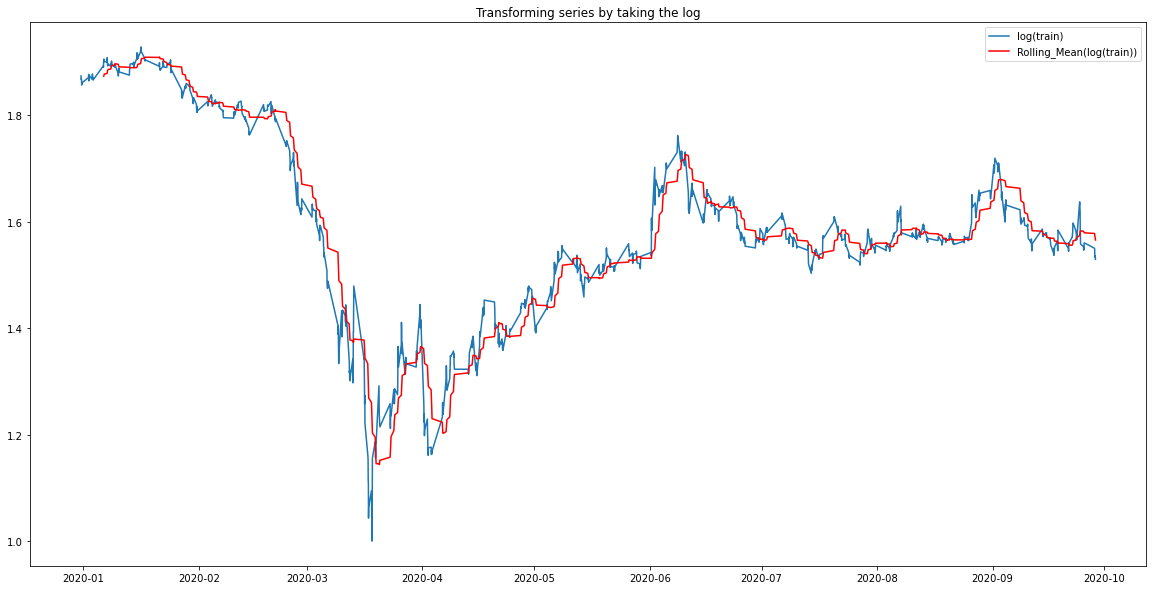

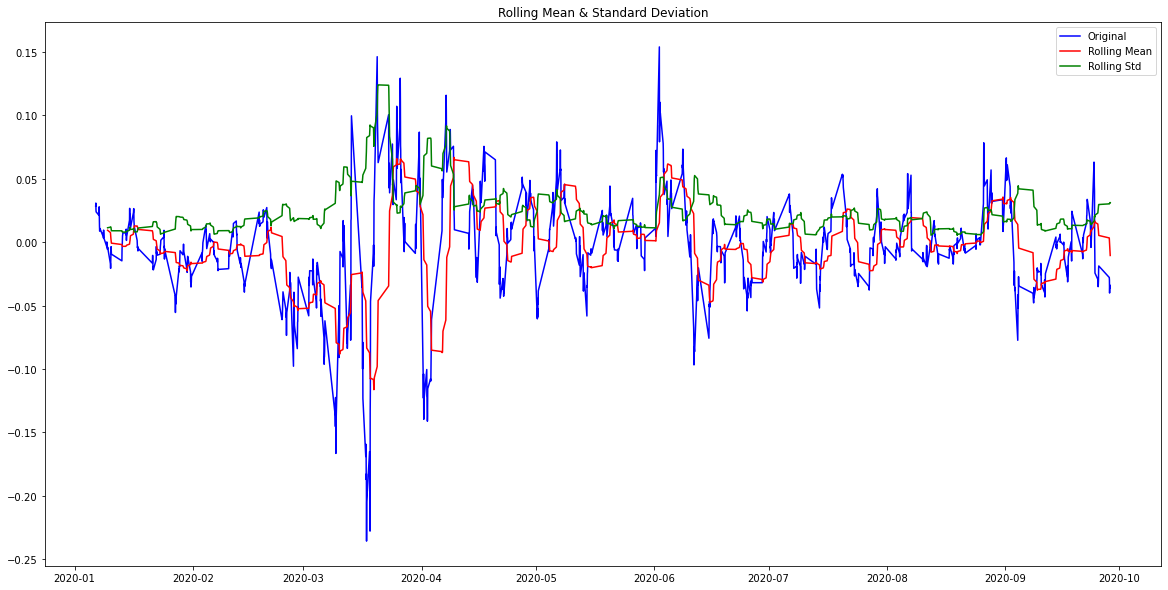

Results of Dickey-Fuller Test:
Test Statistic                -6.758232e+00
p-value                        2.835570e-09
#Lags Used                     1.700000e+01
Number of Observations Used    1.274000e+03
Critical Value (1%)           -3.435493e+00
Critical Value (5%)           -2.863811e+00
Critical Value (10%)          -2.567979e+00
dtype: float64


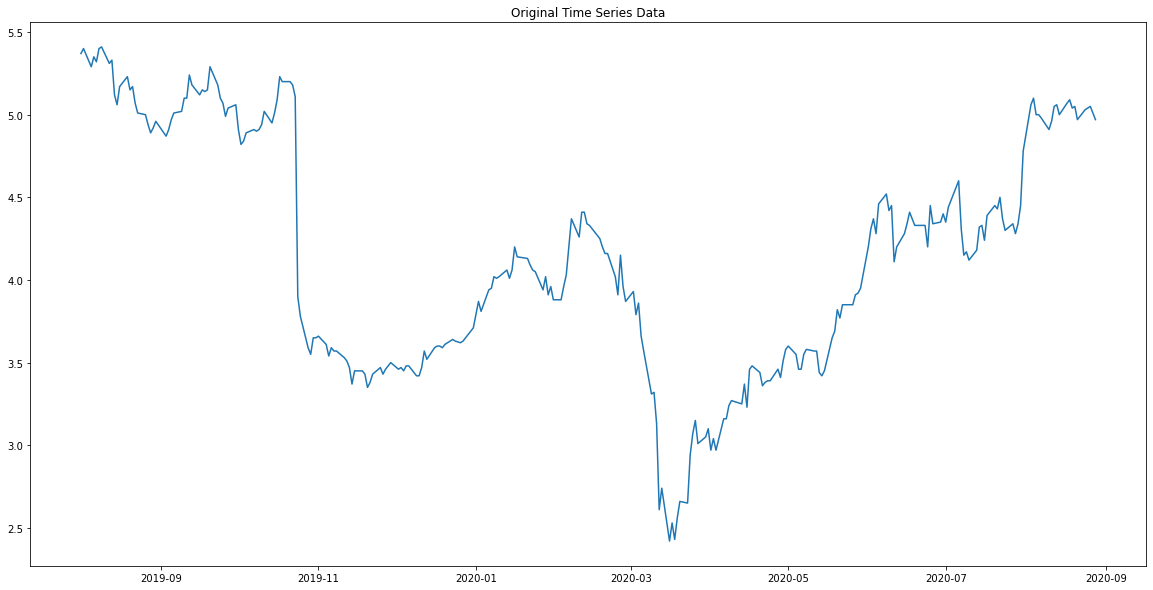

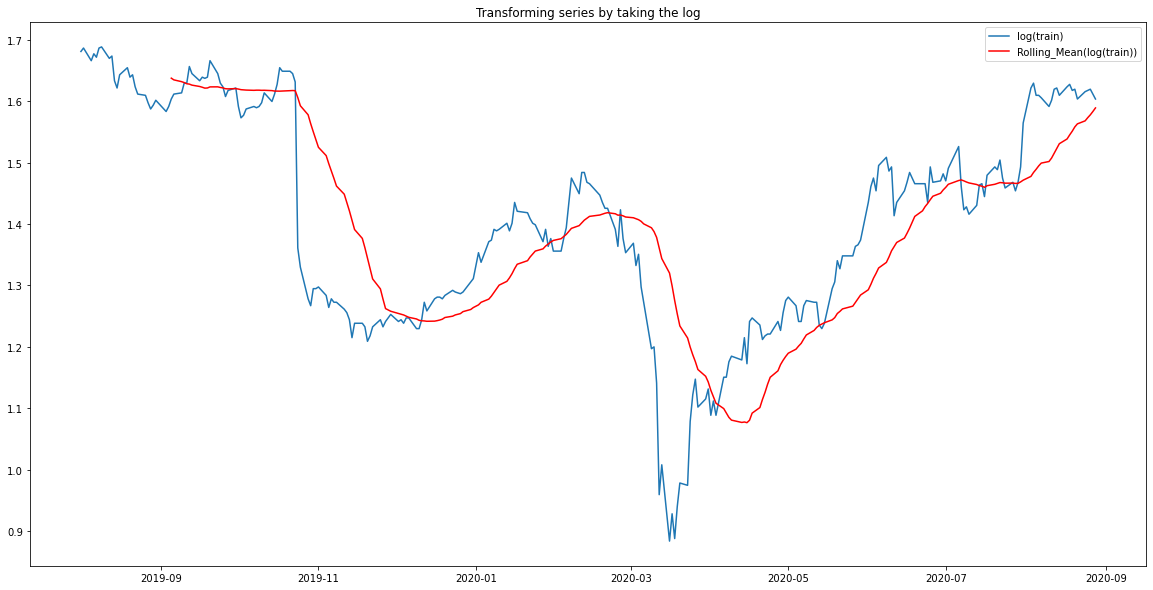

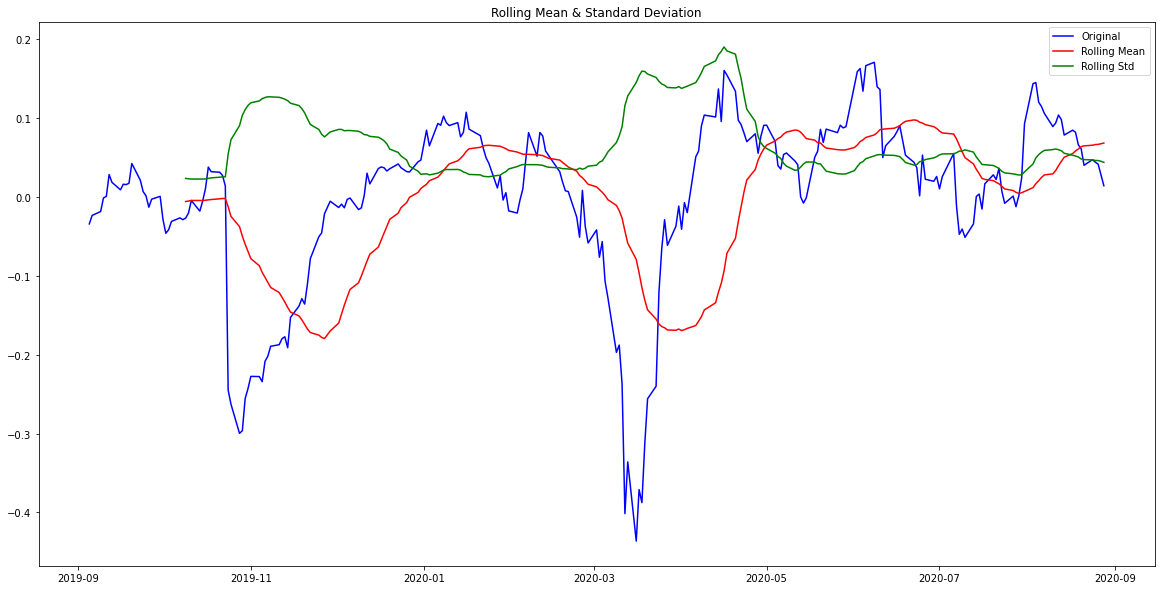

Results of Dickey-Fuller Test:
Test Statistic                  -3.330686
p-value                          0.013561
#Lags Used                       3.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


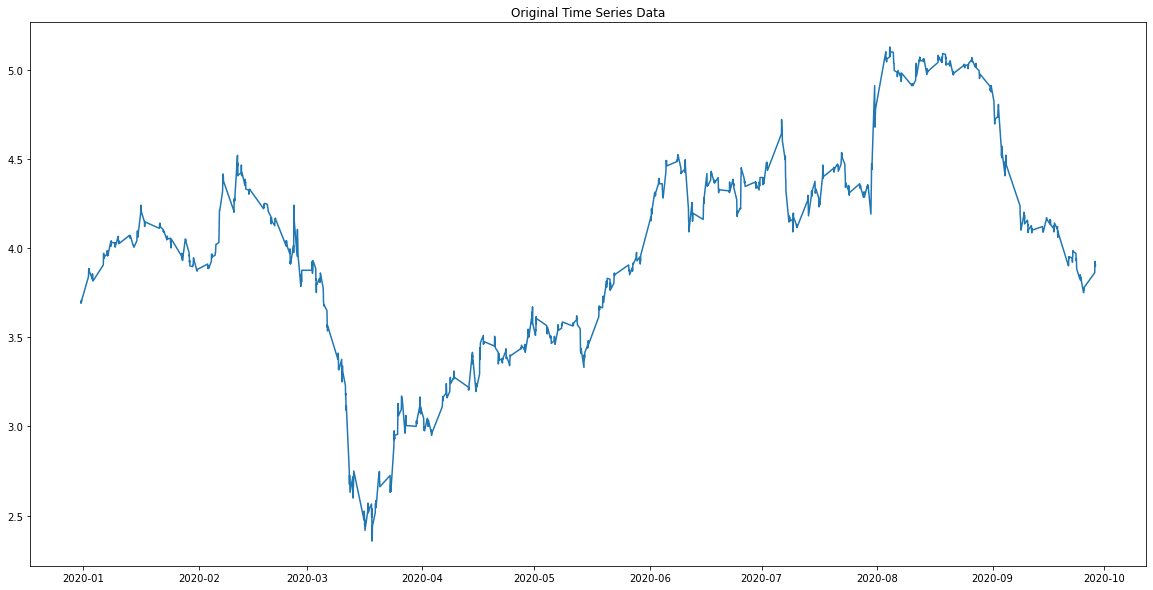

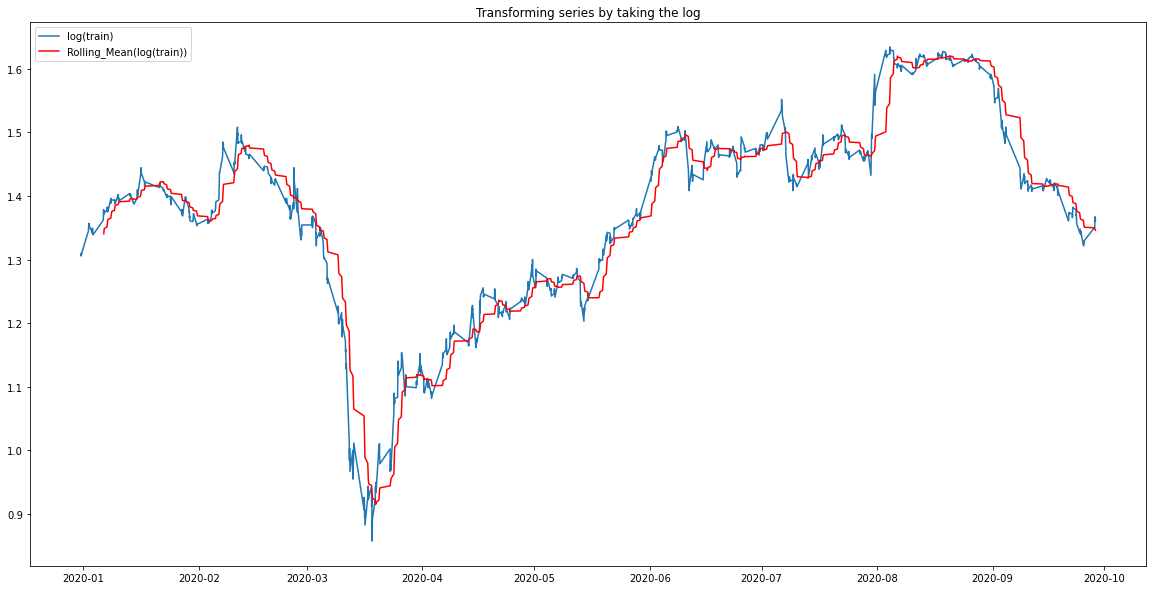

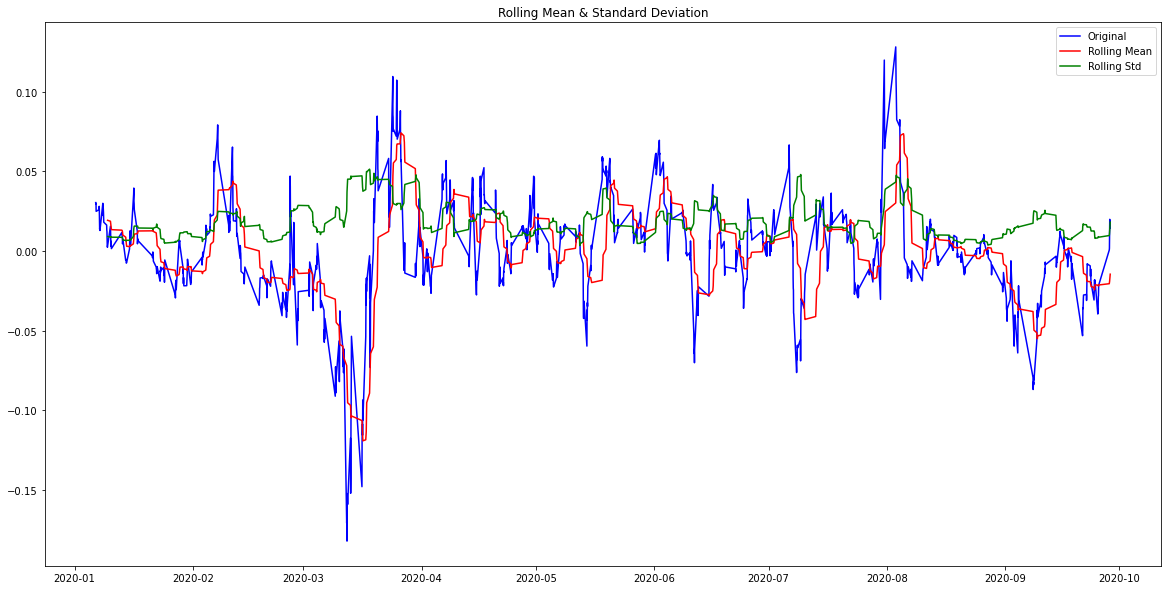

Results of Dickey-Fuller Test:
Test Statistic                -5.684345e+00
p-value                        8.345787e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.276000e+03
Critical Value (1%)           -3.435485e+00
Critical Value (5%)           -2.863808e+00
Critical Value (10%)          -2.567977e+00
dtype: float64


In [8]:
df_amc_train['Log Adj Close'] = detrend_takelog(df_amc_train[['Adj Close']], 25)
df_amc_train_hr['Log Adj Close'] = detrend_takelog(df_amc_train_hr[['Adj Close']], 25)
df_gme_train['Log Adj Close'] = detrend_takelog(df_gme_train[['Adj Close']], 25)
df_gme_train_hr['Log Adj Close'] = detrend_takelog(df_gme_train_hr[['Adj Close']], 25)
df_bb_train['Log Adj Close'] = detrend_takelog(df_bb_train[['Adj Close']], 25)
df_bb_train_hr['Log Adj Close'] = detrend_takelog(df_bb_train_hr[['Adj Close']], 25)
df_nok_train['Log Adj Close'] = detrend_takelog(df_nok_train[['Adj Close']], 25)
df_nok_train_hr['Log Adj Close'] = detrend_takelog(df_nok_train_hr[['Adj Close']], 25)

In [9]:
# Transform the data.
df_a = transform(df_amc_train, 'Log Adj Close', 5)
df_g = transform(df_gme_train, 'Log Adj Close', 5)
df_b = transform(df_bb_train, 'Log Adj Close', 5)
df_n = transform(df_nok_train, 'Log Adj Close', 5)

df_a_r = transform(df_amc_train, 'Return', 5)
df_g_r = transform(df_gme_train, 'Return', 5)
df_b_r = transform(df_bb_train, 'Return', 5)
df_n_r = transform(df_nok_train, 'Return', 5)

df_a_h = transform(df_amc_train_hr, 'Log Adj Close', 7)
df_g_h = transform(df_gme_train_hr, 'Log Adj Close', 7)
df_b_h = transform(df_bb_train_hr, 'Log Adj Close', 7)
df_n_h = transform(df_nok_train_hr, 'Log Adj Close', 7)

df_a_h_r = transform(df_amc_train_hr, 'Return', 7)
df_g_h_r = transform(df_gme_train_hr, 'Return', 7)
df_b_h_r = transform(df_bb_train_hr, 'Return', 7)
df_n_h_r = transform(df_nok_train_hr, 'Return', 7)

The array is not divisible into a 5 dimensional array.
We omit the first 4 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 4 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 4 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 4 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 3 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 3 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 3 entry/entries in the dataset.
The array is not divisible into a 5 dimensional array.
We omit the first 3 entry/entries in the dataset.
The array is not divisible into a 7 dimensional array.
We omit the first 4 entry/entries in the dataset.
The array is not divisible into a 7 dimensional array.


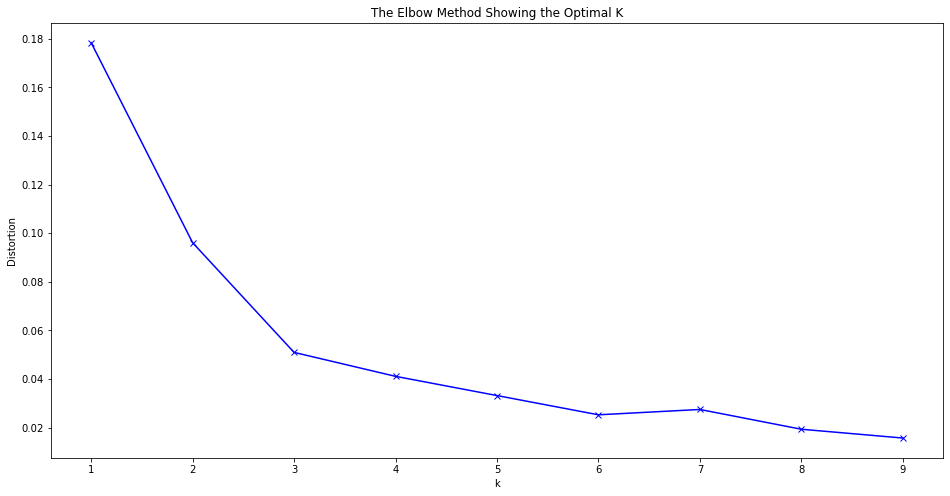

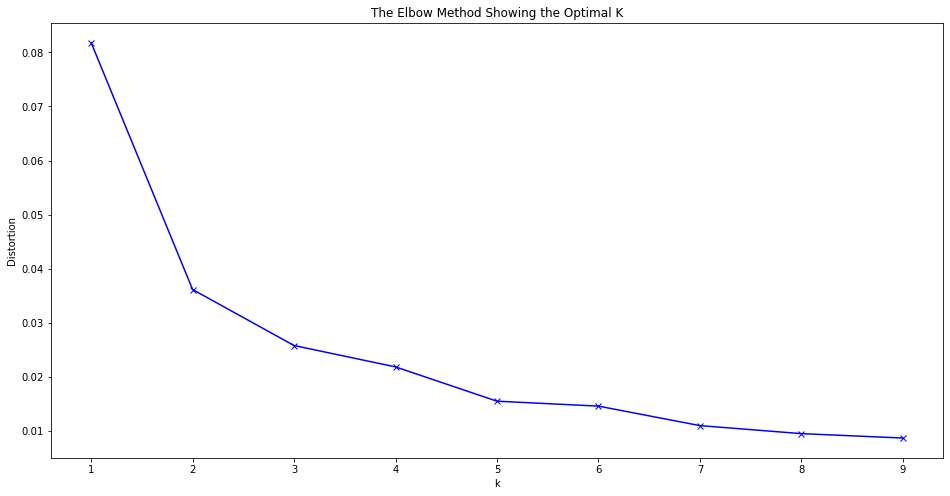

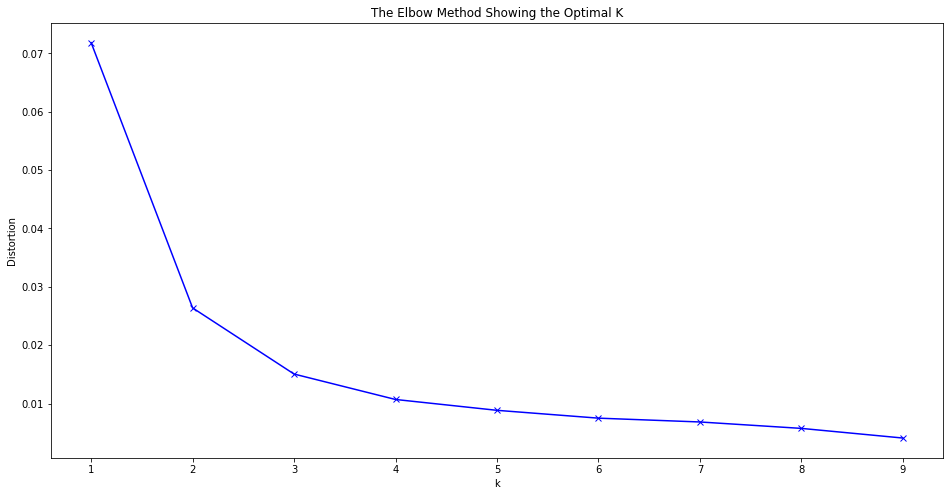

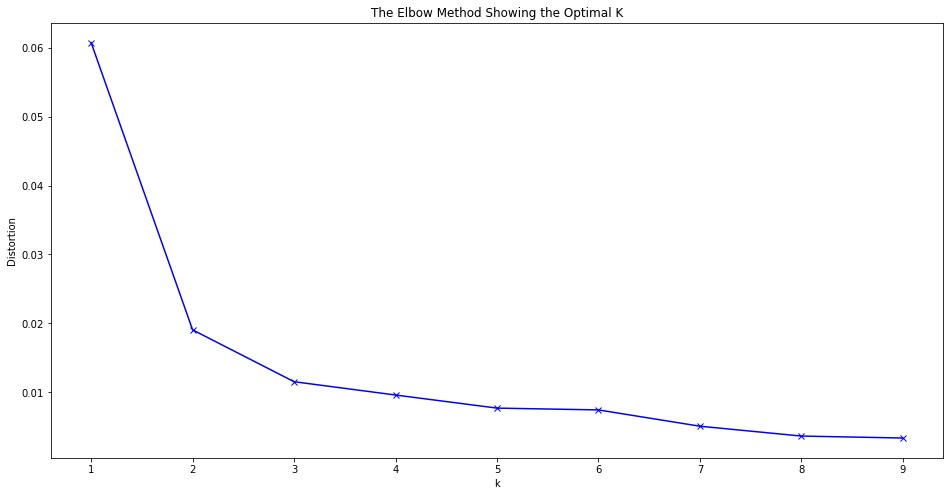

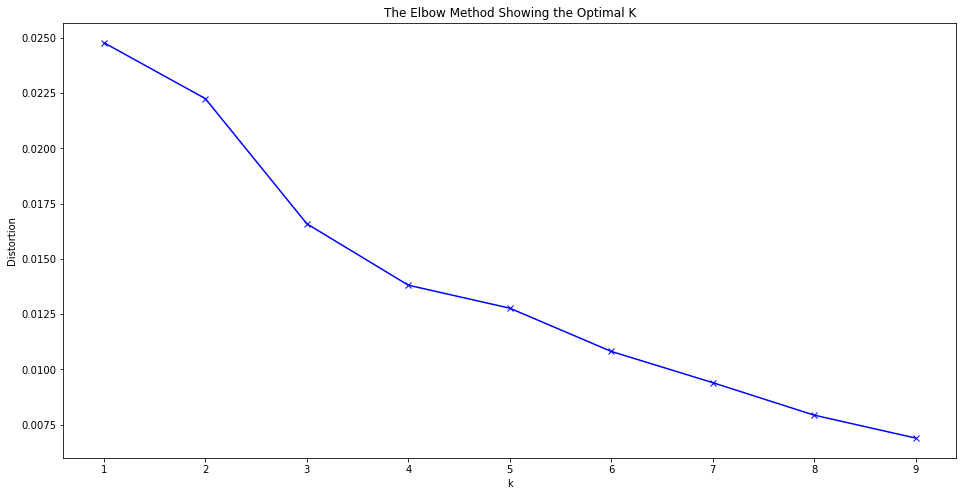

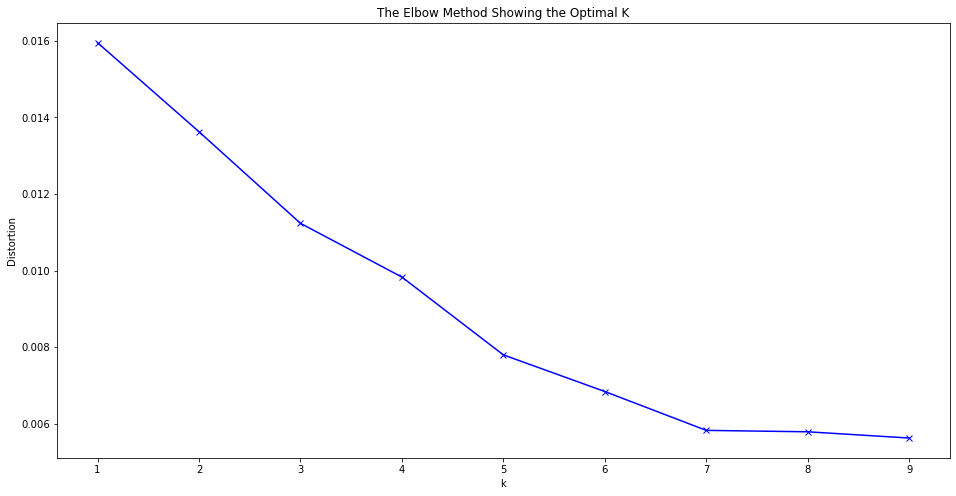

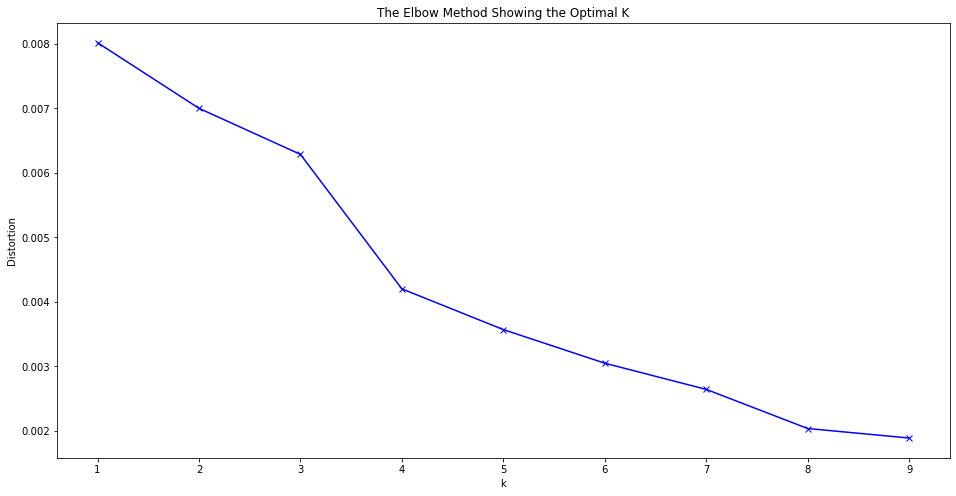

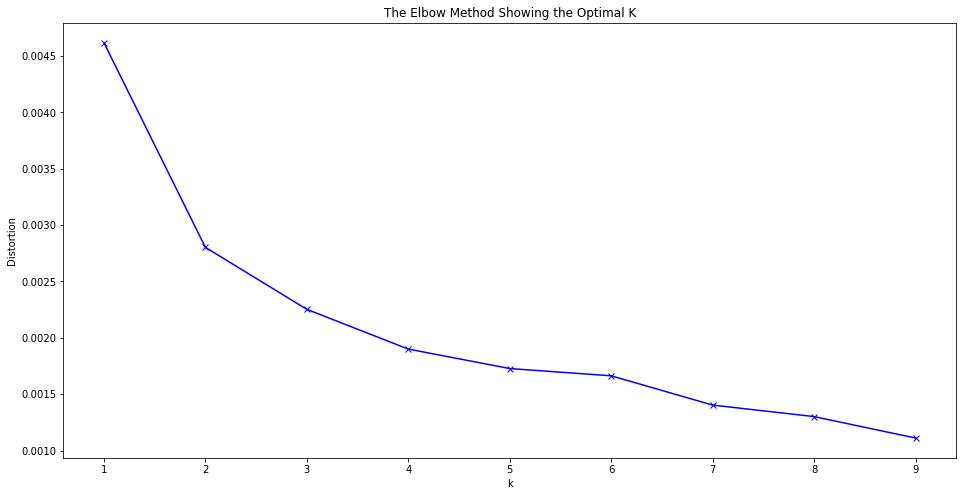

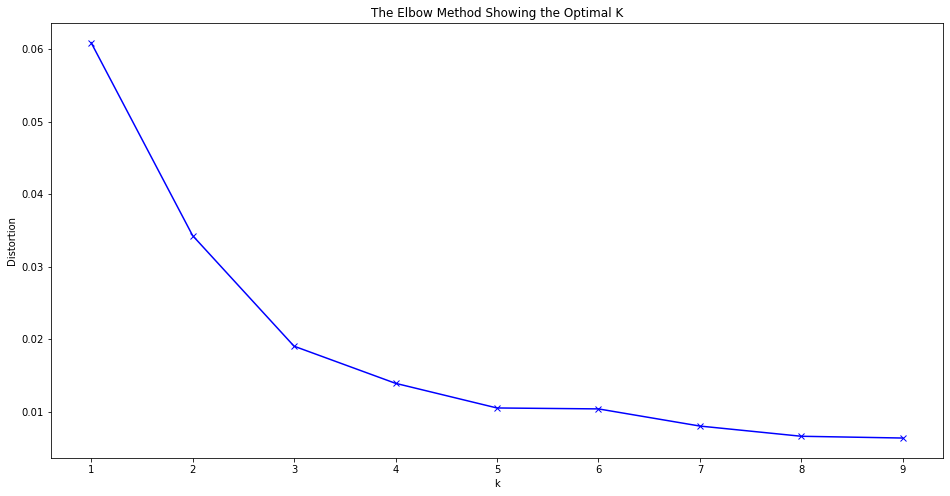

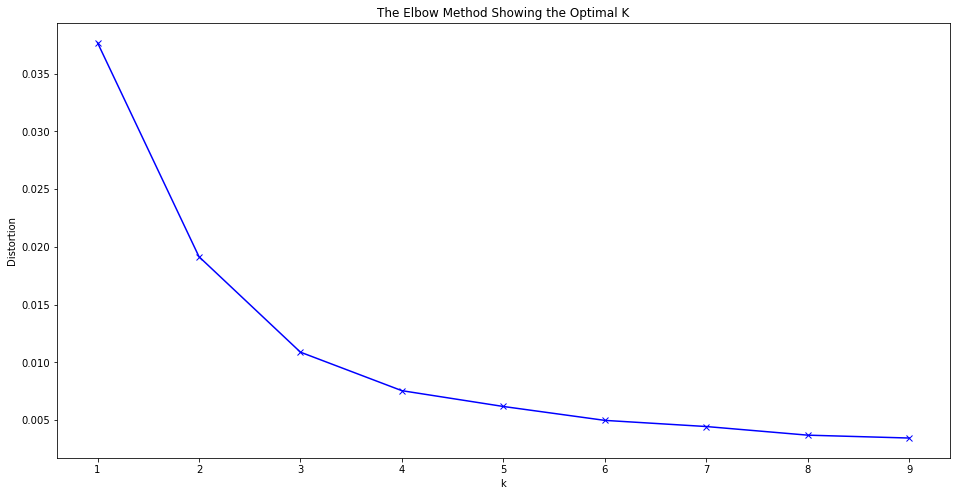

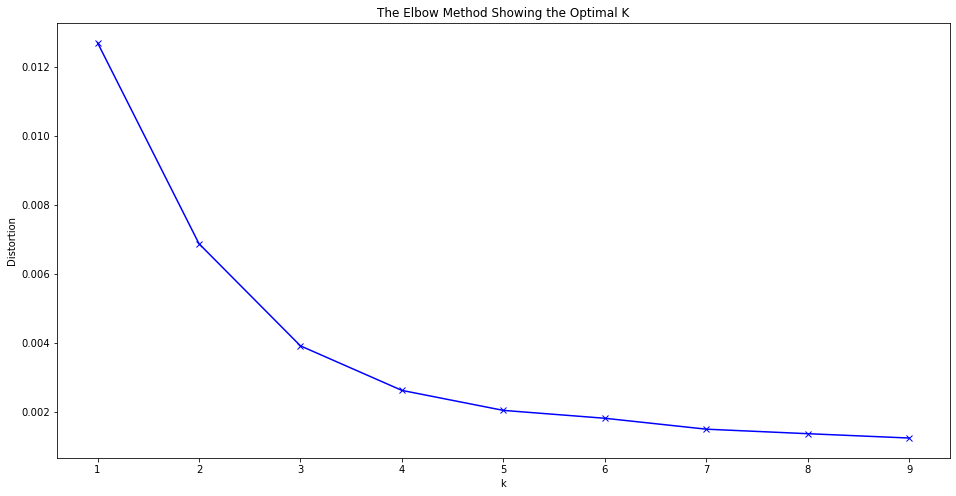

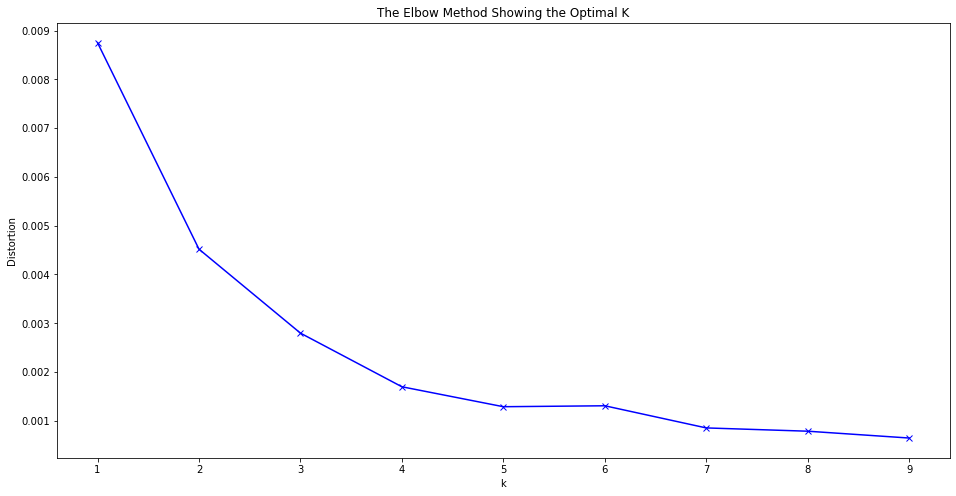

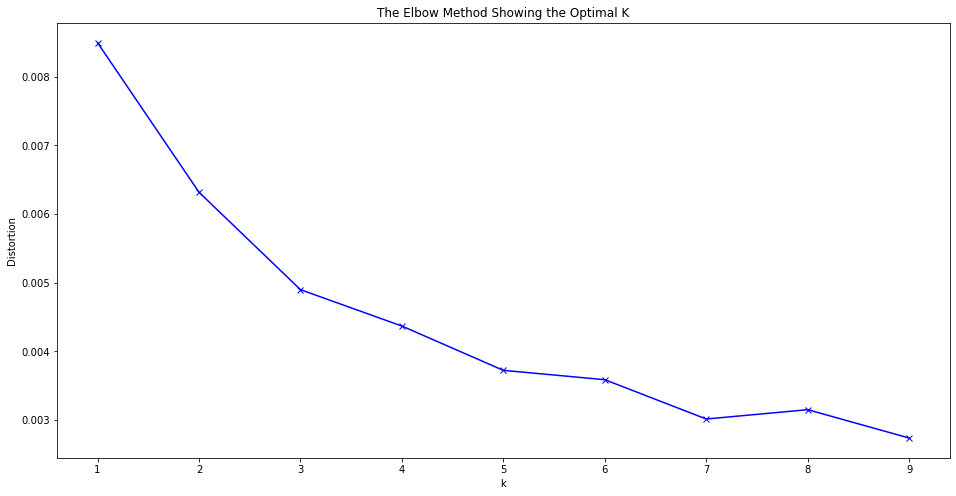

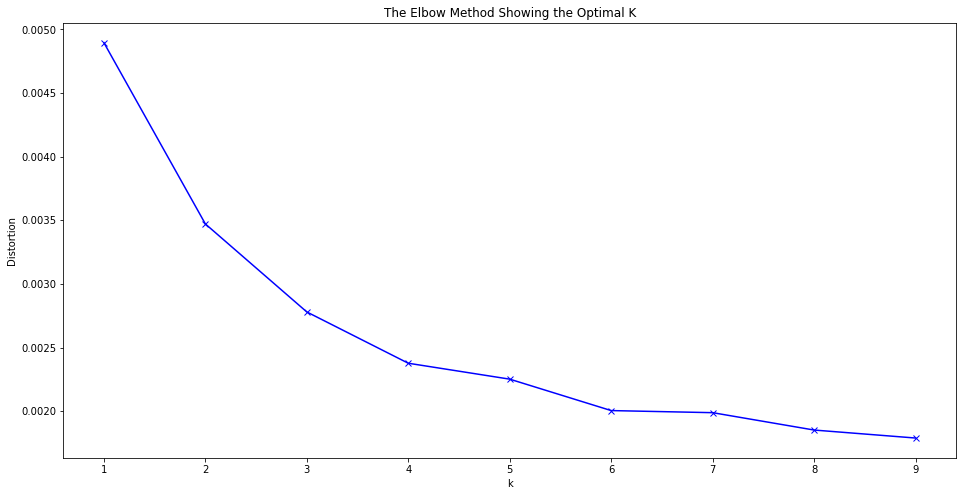

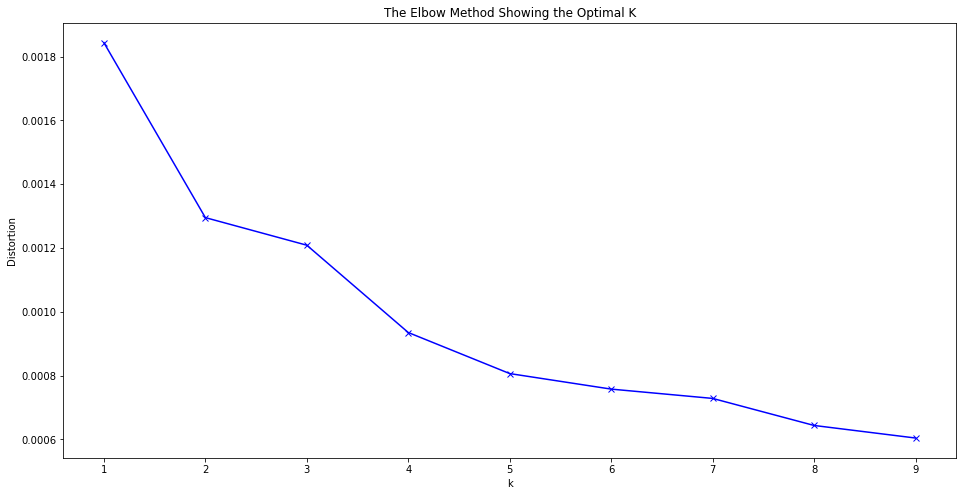

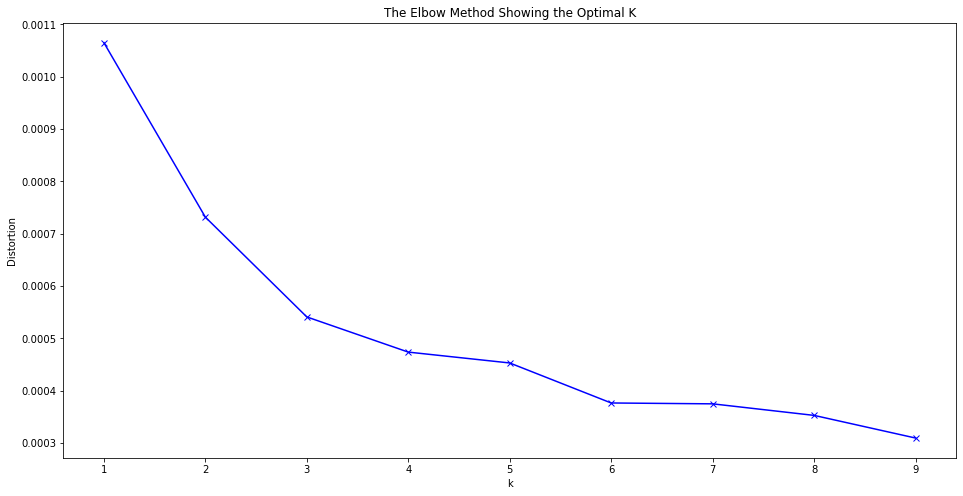

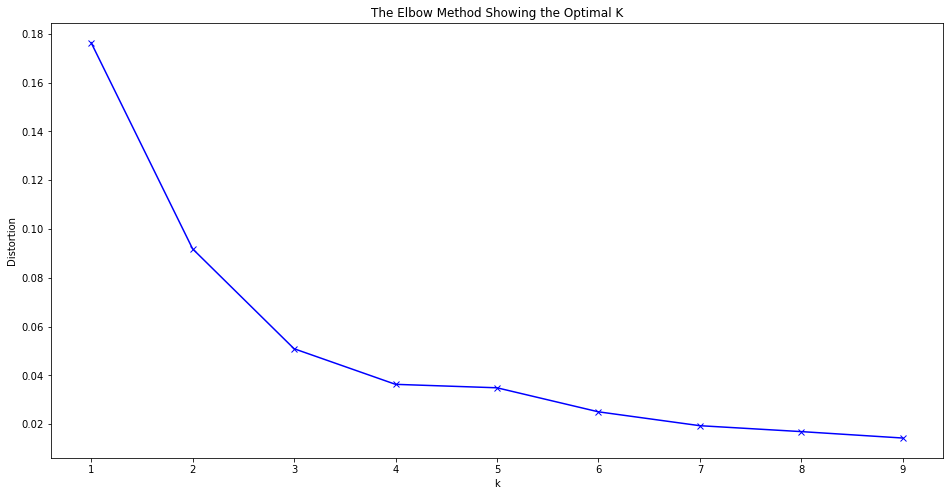

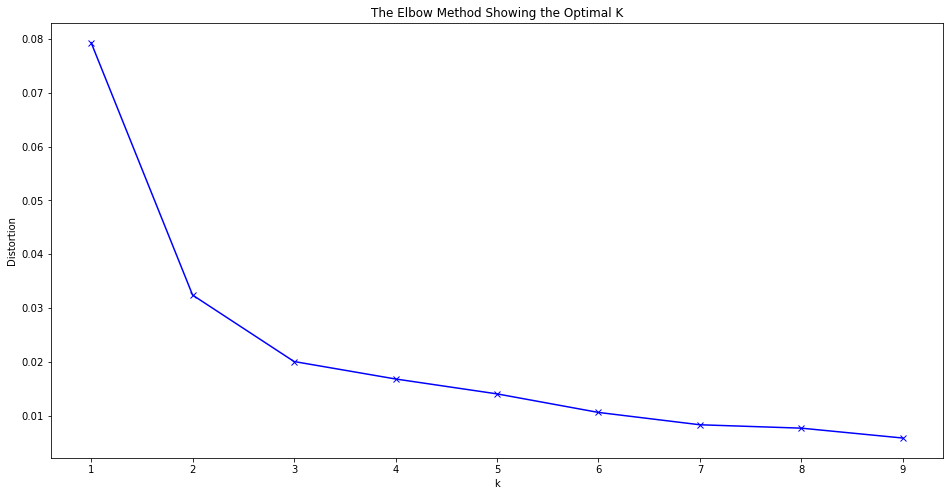

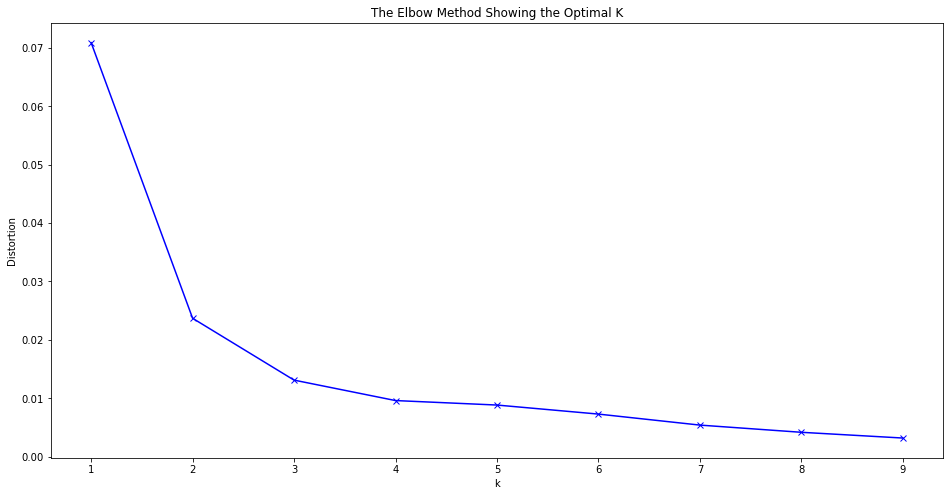

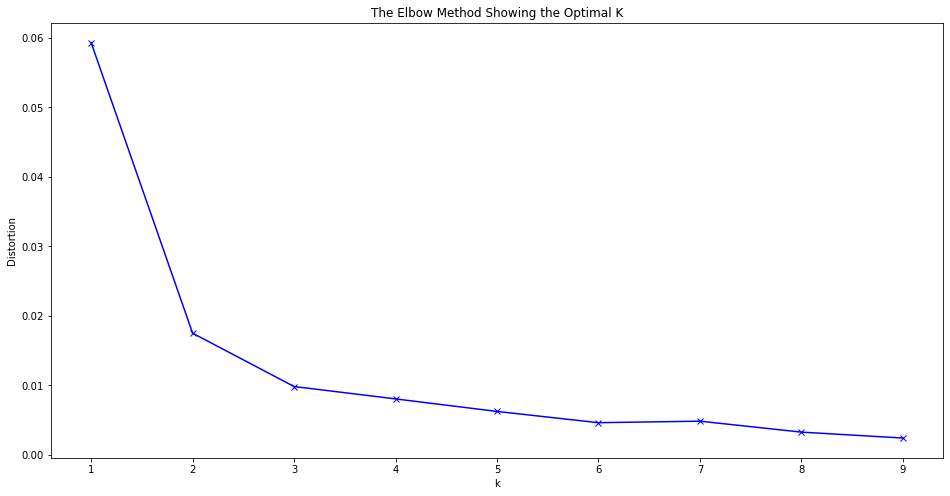

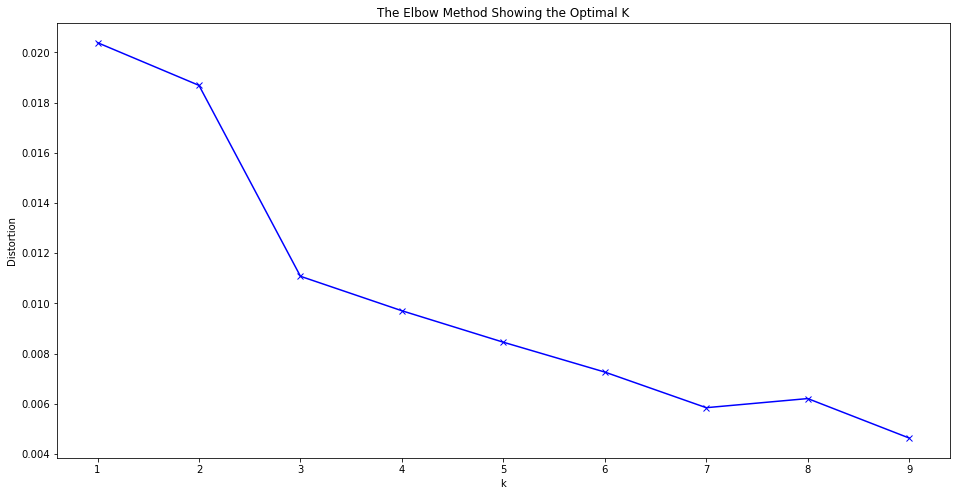

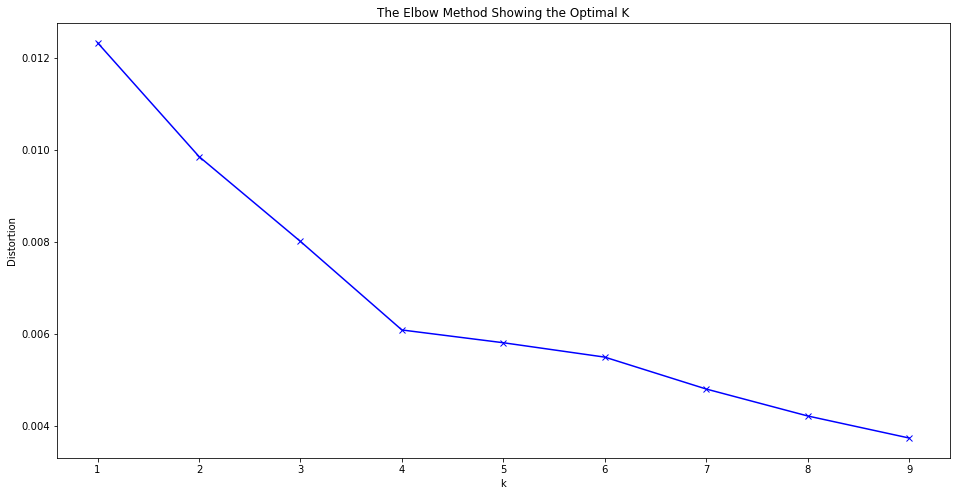

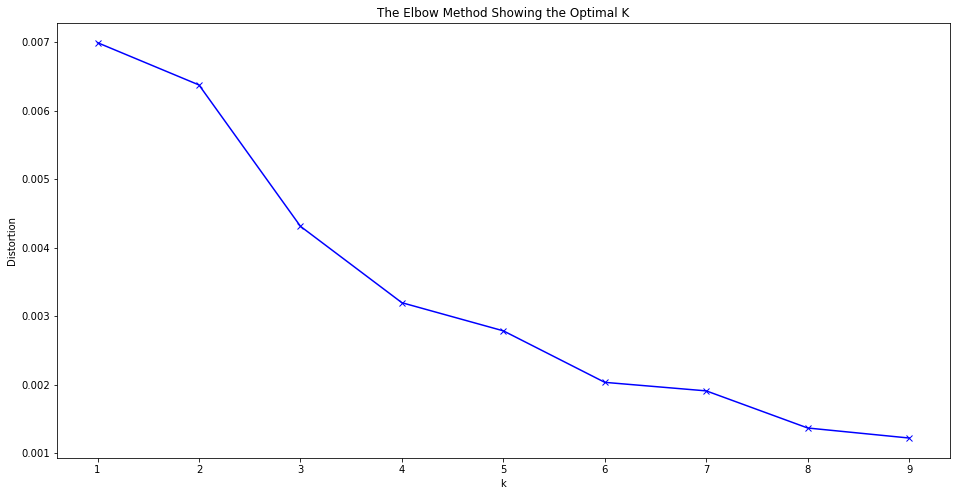

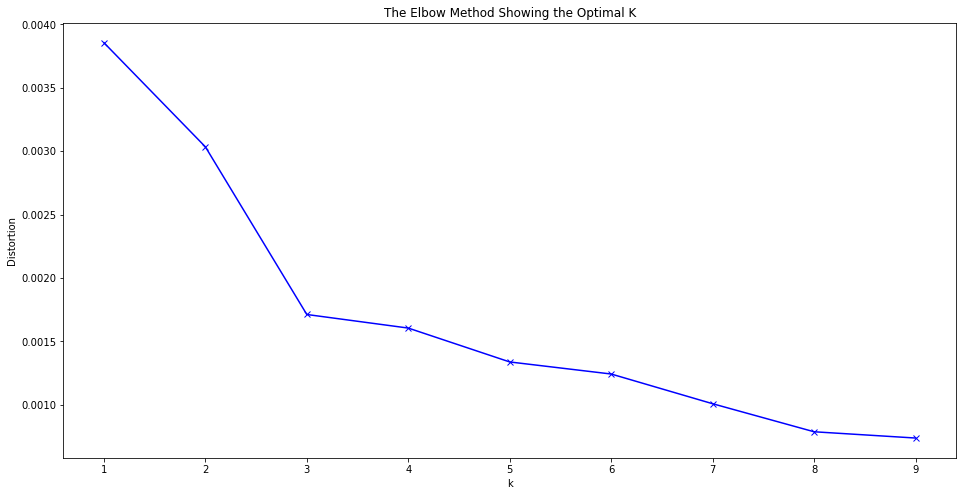

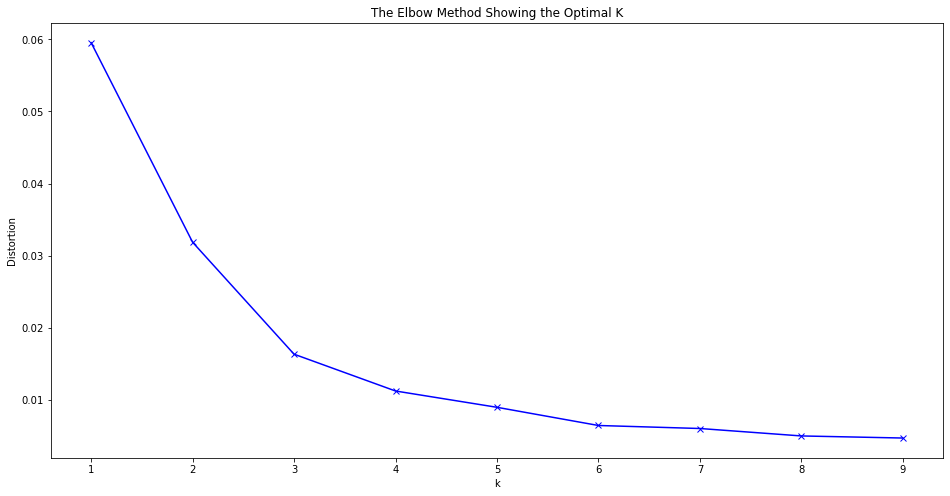

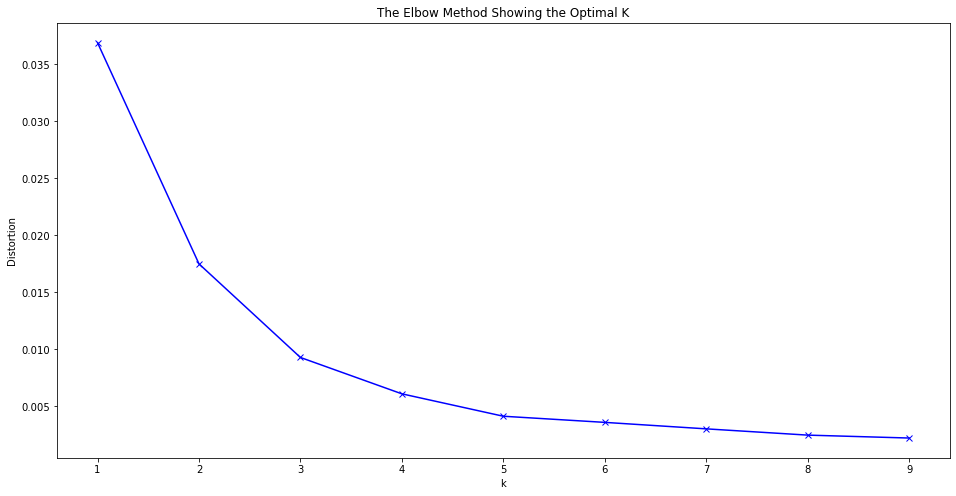

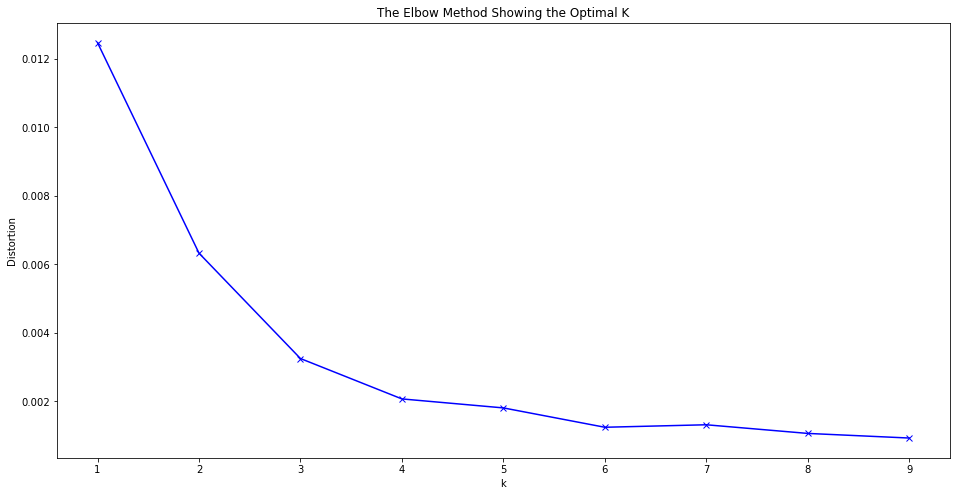

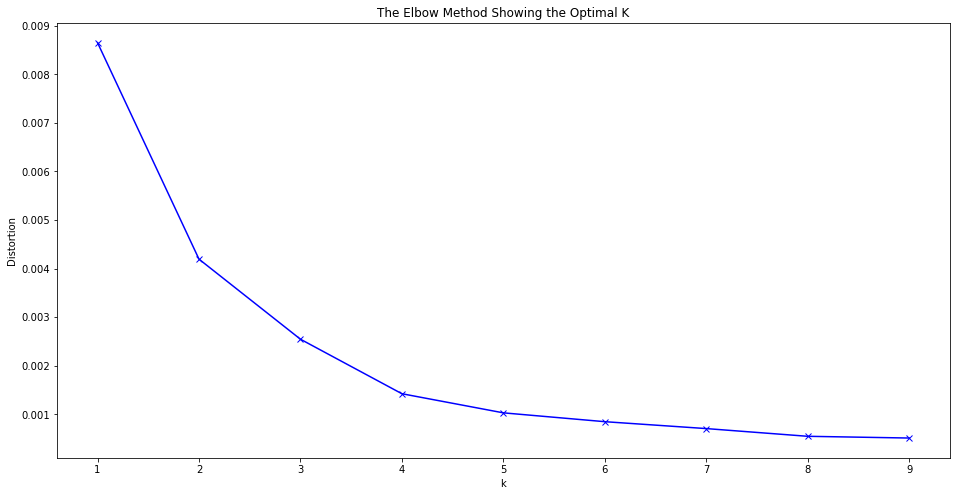

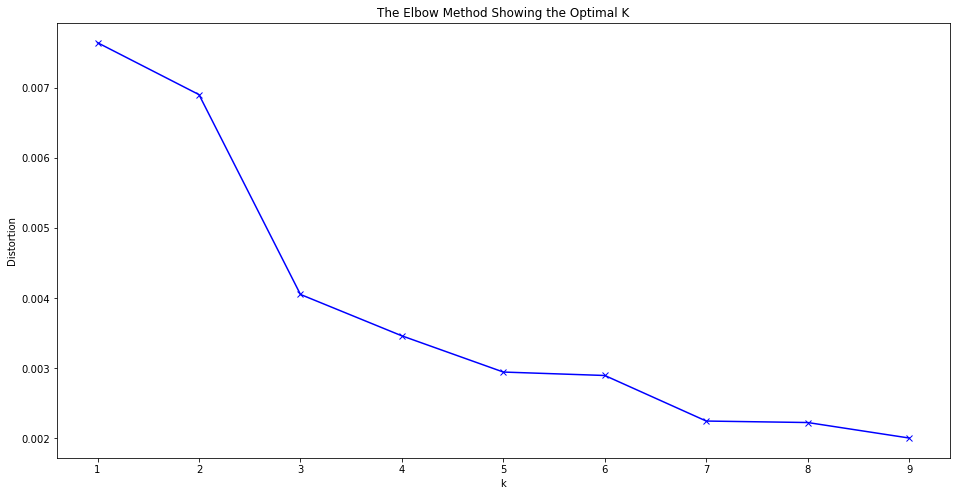

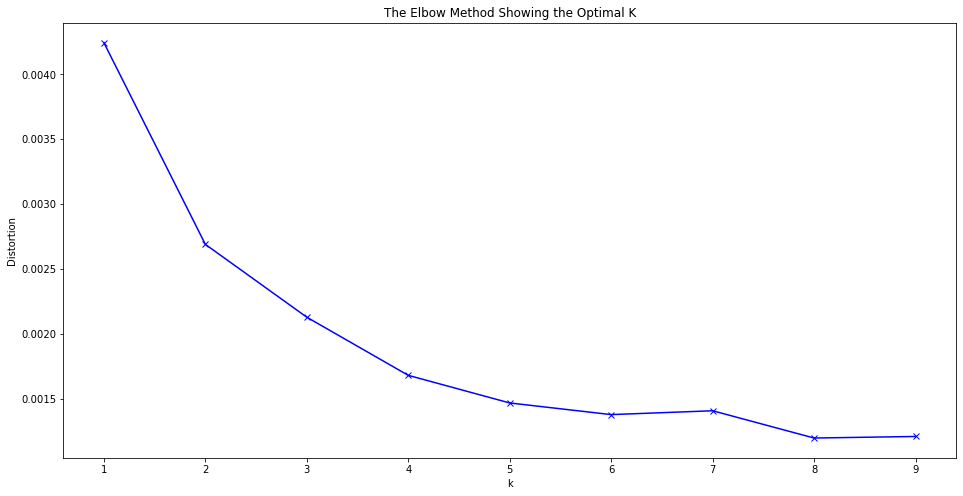

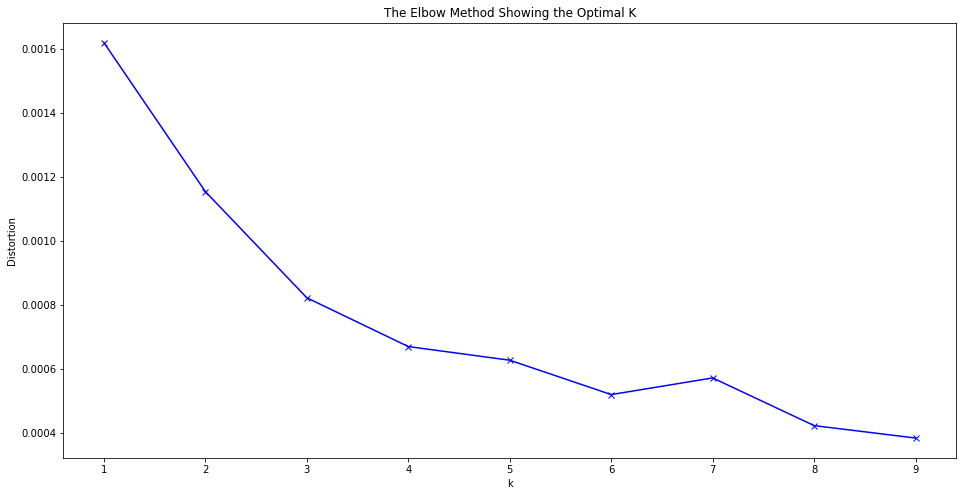

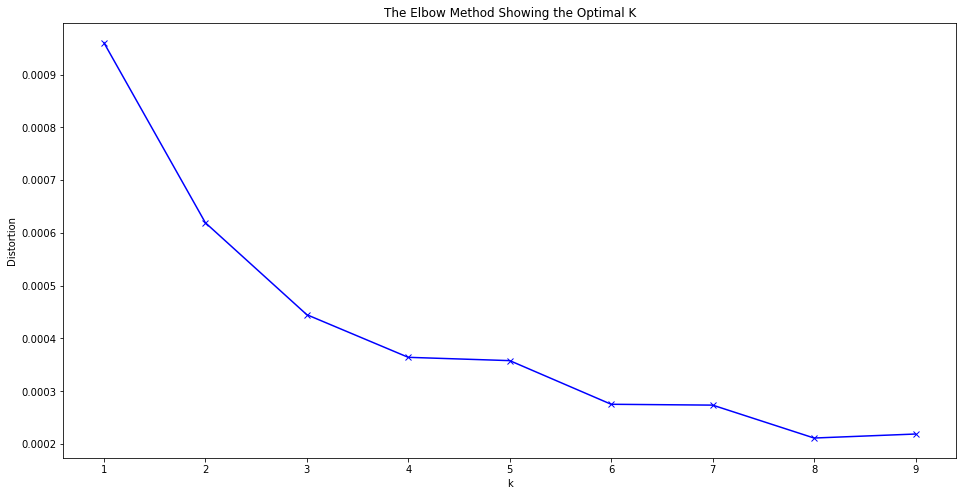

In [23]:
elbow(df_a, "euclidean")
elbow(df_g, "euclidean")
elbow(df_b, "euclidean")
elbow(df_n, "euclidean")
elbow(df_a_r, "euclidean")
elbow(df_g_r, "euclidean")
elbow(df_b_r, "euclidean")
elbow(df_n_r, "euclidean")
elbow(df_a_h, "euclidean")
elbow(df_g_h, "euclidean")
elbow(df_b_h, "euclidean")
elbow(df_n_h, "euclidean")
elbow(df_a_h_r, "euclidean")
elbow(df_g_h_r, "euclidean")
elbow(df_b_h_r, "euclidean")
elbow(df_n_h_r, "euclidean")

elbow(df_a, "dtw")
elbow(df_g, "dtw")
elbow(df_b, "dtw")
elbow(df_n, "dtw")
elbow(df_a_r, "dtw")
elbow(df_g_r, "dtw")
elbow(df_b_r, "dtw")
elbow(df_n_r, "dtw")
elbow(df_a_h, "dtw")
elbow(df_g_h, "dtw")
elbow(df_b_h, "dtw")
elbow(df_n_h, "dtw")
elbow(df_a_h_r, "dtw")
elbow(df_g_h_r, "dtw")
elbow(df_b_h_r, "dtw")
elbow(df_n_h_r, "dtw")